## Set up Google Colab environment

In [1]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    ## Specify a directory in Google Drive
    dir = '/content/drive/My Drive/Colab Notebooks/Keras_Dense_Only_MNIST'
    os.chdir(dir)
    #os.getcwd()
    #os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if colab:
    ## Check the uptime. (Google Colab reboots every 12 hours)
    !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
    ## Check the GPU info
    !nvidia-smi
    ## Check the Python version
    !python --version

Uptime is 3.51549 hours (12655.77 sec)
Sun Jan 27 12:17:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                     

## Import modules

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

y_train = y_train[:1000]
y_test = y_test[:1000]

x_train = x_train[:1000].reshape(-1, 28 * 28) / 255.0
x_test = x_test[:1000].reshape(-1, 28 * 28) / 255.0

input_shape = (28 * 28,)

## Set up model

In [0]:
# Returns a short sequential model
def create_model(input_shape):
    model = tf.keras.models.Sequential([
            keras.layers.Dense(512, activation=tf.keras.activations.relu, input_shape=input_shape),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(10, activation=tf.keras.activations.softmax)
            ])
  
    model.compile(optimizer='adam', 
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
    return model

## Fit model

In [13]:
### If resume_if_possible = True, fitting can resume using a model file. 
resume_if_possible = True 

### Set resume_if_possible = False to force fitting from scratch.
## resume_if_possible = False 

batch_size = 64
epochs = 100


class ModelFileProcessing():
    def __init__(self, model_file_prefix = 'model_epoch', model_file_suffix = '.hdf5', verbose = 2):
        self.model_file_prefix = model_file_prefix
        self.model_file_suffix = model_file_suffix
        self.verbose = verbose
        model_file_path = model_file_prefix + '{epoch:06d}' + model_file_suffix
        self.model_file_path = model_file_path
        self.update()
    def update(self):
        model_file_prefix = self.model_file_prefix
        model_file_suffix = self.model_file_suffix
        model_file_list = glob.glob(model_file_prefix + '*' + model_file_suffix)
        if self.verbose >= 2:
            print('model_file_list: ', model_file_list)
        self.model_file_list = model_file_list
        model_file_exists = len(self.model_file_list) >= 1
        self.model_file_exists = model_file_exists

        latest_model_file = model_file_list[-1] if model_file_exists else None
        self.latest_model_file = latest_model_file

        latest_epoch = int(latest_model_file[len(model_file_prefix):-len(model_file_suffix)]) \
            if model_file_exists else 0
        self.latest_epoch = latest_epoch

        multiple_model_files_exist = len(model_file_list) >= 2
        self.multiple_model_files_exist = multiple_model_files_exist
    def clean_up_old(self):
        self.update()
        ## Delete all model files excpet the latest to save space
        if self.multiple_model_files_exist:
            for f in self.model_file_list[:-1]:
                os.remove(f)   
    def clean_up_all(self):
        self.update()
        ## Delete all model files if they exist.
        if self.model_file_exists:
            for f in self.model_file_list:
                os.remove(f)   

mfp = ModelFileProcessing()

class LogFileProcessing():
    def __init__(self, log_file_path = 'training_log.csv', verbose = 2):
        self.log_file_path = log_file_path
        self.verbose = verbose
        self.update()
    def update(self):
        log_file_path = self.log_file_path
        log_file_list = glob.glob(log_file_path)
        self.log_file_list = log_file_list
        if self.verbose >= 2:
            print('log_file_list:', log_file_list)
        log_file_exists = len(log_file_list) >= 1
        self.log_file_exists = log_file_exists
    def truncate(self):
        log_file_path = self.log_file_path
        self.update()
        ## Remove rows after the epoch of the latest saved model 
        ## (needed because save_best_only option of checkpoint is set to True.)
        with open(log_file_path, 'r') as f:
            lines = f.readlines()
        if self.verbose >= 2:
            print('log file contents read:', lines)
        lines_truncated = lines[:(mfp.latest_epoch+1)]
        with open(log_file_path, 'w') as f:
            f.writelines(lines_truncated)
        if self.verbose >= 2:
            print('new log file contents', lines_truncated)
    def clean_up(self):
        if self.log_file_exists:
            for f in self.log_file_list:
                os.remove(f)  
    
lfp = LogFileProcessing()

resume_flag = resume_if_possible and mfp.model_file_exists and lfp.log_file_exists
  
if resume_flag:
    latest_epoch = mfp.latest_epoch
    mfp.clean_up_old() ## To do: should be ok to delete this
    lfp.truncate() ## Truncate the log file
    ## Load the saved model
    model = keras.models.load_model(mfp.latest_model_file)
    print('Use {} to resume fitting.'.format(mfp.latest_model_file))

if not resume_flag:
    latest_epoch = 0
    ## Delete all model files and the log file if they exist.
    mfp.clean_up_all()
    lfp.clean_up()
    ## Create a basic model instance
    model = create_model(input_shape)
    print('Model created.')

model.summary()

## Create checkpoint callback
check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = mfp.model_file_path, 
                                                 monitor = 'val_acc',
                                                 verbose = 1,
                                                 save_best_only = True,
                                                 mode = 'auto',
                                                 save_weights_only = False,
                                                 period = 1)

import time          
class CompTime(keras.callbacks.Callback):
    def __init__(self, log_file_path = 'training_log.csv', verbose = 2):
        self.log_file_path = log_file_path
        self.verbose = verbose
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        comp_time = time.time() - self.epoch_time_start
        logs['Comp_time'] = comp_time
        print('Computation time: {} sec'.format(comp_time))
        cum_comp_time_prev = 0.0
        try:
            log_df = pd.read_csv(self.log_file_path)
            if log_df.shape[0] >= 1:
                cum_comp_time_prev = float(log_df.iloc[-1]['Cum_comp_time'])
        except:
            print('Failed to read the previous cumulative computation time, but continue training.')
        logs['Cum_comp_time'] = cum_comp_time_prev + comp_time

comp_time_ = CompTime()

## Create CSV logger callback
csv_logger_ = tf.keras.callbacks.CSVLogger(filename = lfp.log_file_path, separator=',',
                                           append = resume_flag)

class CSVLogCleanup(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        mfp.clean_up_old()
    
csv_log_cleanup_ = CSVLogCleanup()
        
## Create early stopping callback
early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                   min_delta=0, 
                                                   patience=5, 
                                                   verbose=1, 
                                                   mode='auto', 
                                                   baseline=None)

## Fit 
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, initial_epoch = latest_epoch,
          validation_data = (x_test,y_test), shuffle = True,
          callbacks = [check_point_, comp_time_, csv_logger_, csv_log_cleanup_, early_stopping_])

## Show final model performance metrics
mfp.update()
model = keras.models.load_model(mfp.latest_model_file)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)
print("Final Model:  {}  \n  val_acc:  {:8.6f}\n  val_loss: {:8.6f}".format(mfp.latest_model_file, val_acc, val_loss))

model_file_list:  ['model_epoch000019.hdf5']
log_file_list: ['training_log.csv']
model_file_list:  ['model_epoch000019.hdf5']
log_file_list: ['training_log.csv']
log file contents read: ['epoch,Comp_time,Cum_comp_time,acc,loss,val_acc,val_loss\n', '0,0.720329999923706,0.720329999923706,0.5749999995231628,1.4753244695663452,0.7450000004768371,0.9221851501464844\n', '1,0.14707708358764648,0.8674070835113524,0.8469999990463257,0.5640698041915894,0.7980000004768372,0.6294080820083618\n', '2,0.14660000801086426,1.0140070915222168,0.8930000004768371,0.368639003276825,0.8139999990463257,0.5696973586082459\n', '3,0.1452193260192871,1.159226417541504,0.924,0.27945285058021546,0.8409999995231628,0.48491630506515504\n', '4,0.15062308311462402,1.3098495006561282,0.9450000004768372,0.22803925132751465,0.853,0.46436224937438964\n', '5,0.15938234329223633,1.4692318439483645,0.9689999995231628,0.16134476494789124,0.8599999995231629,0.43277615594863894\n', '6,0.14766907691955566,1.6169009208679201,0.97

log_file_list: ['training_log.csv']


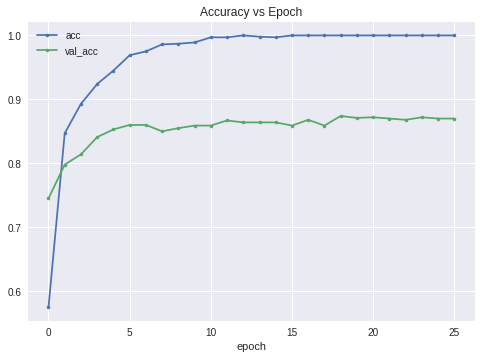

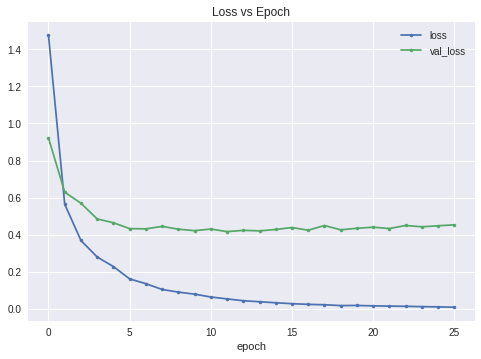

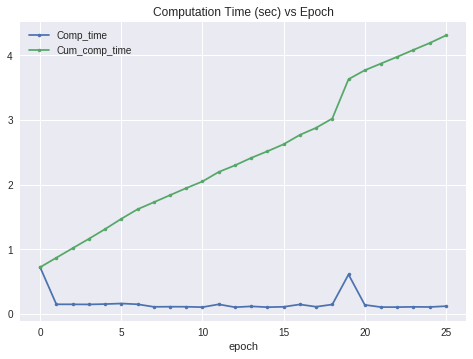

,epoch,Comp_time,Cum_comp_time,acc,loss,val_acc,val_loss
0,0,0.720330,0.720330,0.575,1.475324,0.745,0.922185
1,1,0.147077,0.867407,0.847,0.564070,0.798,0.629408
2,2,0.146600,1.014007,0.893,0.368639,0.814,0.569697
3,3,0.145219,1.159226,0.924,0.279453,0.841,0.484916
4,4,0.150623,1.309850,0.945,0.228039,0.853,0.464362
5,5,0.159382,1.469232,0.969,0.161345,0.860,0.432776
6,6,0.147669,1.616901,0.975,0.135569,0.860,0.431334
7,7,0.108131,1.725032,0.986,0.104291,0.850,0.444917
8,8,0.109898,1.834930,0.987,0.089951,0.855,0.429585
9,9,0.109271,1.944201,0.989,0.079039,0.859,0.421798


In [14]:
## Plot the results
lfp.update()
if lfp.log_file_exists:
    log_df = pd.read_csv(lfp.log_file_path)
    log_df.set_index('epoch')[['acc', 'val_acc']].plot(style='.-', title='Accuracy vs Epoch')
    plt.show()
    log_df.set_index('epoch')[['loss', 'val_loss']].plot(style='.-', title='Loss vs Epoch')
    plt.show()
    log_df.set_index('epoch')[['Comp_time', 'Cum_comp_time']].plot(style='.-', title='Computation Time (sec) vs Epoch')
    plt.show()
    # pd.options.display.max_rows = 8
    display(log_df)

References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint